## Материалы
[презентация](https://disk.yandex.ru/i/2O3fSudO5SZZIA)

[дашборд](https://public.tableau.com/app/profile/aleksander2404/viz/final_dash_16606445039010/Dashboard1)


## Проект для Яндекс практикум
## Банки

### Банки — Анализ оттока клиентов
###  Задача:
- Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.
###  План работы:
1. Проведем предобработку данных
- посмотрим и поверхностно оценим данные
- проверим дубликаты (удалим, если таковые найдутся)
- приведем данные к хорошему стилю (если потребуется)
- проверим наличие пропусков, оценим критичность и решим, что с ними делать
2. Проведем исследовательский анализ данных
- посмотрим гистограммы 
- оценим данные методом describe()
- оценим выбросы и их критичность для рассчетов
- оценим зависимость данных, построим матрицу корреляций 
3. Сформулируем и проверим статистические гипотезы
- средняя заработная плата между теми клиентами, которые ушли и теми, которые остались равна 
- вторую гипотезу я собираюсь вывести на основании полученных ранее данных
4. Сделать итоговые выводы по проекту
5. Дать краткие рекомендации для бизнеса

Описание колонок с анными

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

### Предобработка данных
#### Посмотрим и поверхностно оценим данные

In [1]:
# загружаем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score
from warnings import filterwarnings
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
filterwarnings("ignore")

In [2]:
# загрузим данные

try:
    df = pd.read_csv('C:/Users/astoi/Desktop/практикум/ПРОЕКТ/bank_dataset.csv')
except:
    df = pd.read_csv('/datasets/bank_dataset.csv')
    
df.head() 

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


- сразу видим, что есть пропуски
- название колонок нужно привести к обему стилю

In [3]:
# посмотрим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


#### проверим наличие дубликатов

In [4]:
df.duplicated().sum()

0

дубликаты отсутствуют, это хорошо

In [5]:
print('уникальные пользователи', df['userid'].nunique())
print('процент уникальных пользователей', df['userid'].nunique()/len(df['userid'])*100, '%')

уникальные пользователи 10000
процент уникальных пользователей 100.0 %


- судя по ID, все пользователи - уникальные

#### приведем данные к хорошему стилю

In [6]:
df.columns=df.columns.str.lower()
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

#### проверим наличие пропусков

In [7]:
print(df['balance'].isna().sum())
print('процент пропусков', ((df['balance'].isna().sum())/len(df)*100), '%')

3617
процент пропусков 36.17 %


количество пропусков критично, удалять нельзя

сначала посмотрим, в каких группах и в каком количестве присутствуют пропуски

In [8]:
# напишем функцию для категоризации данных по остатку на счете
def balance_group (balance):
    if balance >= 0:
        return 'баланс not null'
    return 'баланс is nan'

# добавим столбец `balance_group`, содержащий категории
df['balance_group'] = df['balance'].apply(balance_group)
# проверим корректность заполнения категорий (положительный баланс должен быть в 6383 случаях)
df['balance_group'].value_counts()

баланс not null    6383
баланс is nan      3617
Name: balance_group, dtype: int64

Построим графики и посмотрим, какие закономерности можно проследить

In [9]:
def function_hist_nan(data,column, name):
    sns.displot(data,x=column,hue='balance_group')
    plt.title('Распределение '+name, fontsize=13)
    plt.ylabel('Распределение')
    plt.show()

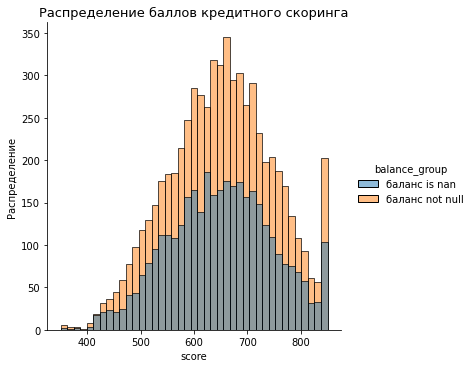

In [10]:
function_hist_nan(df, df['score'],'баллов кредитного скоринга')

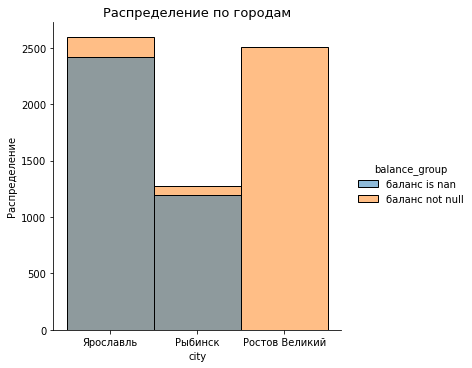

In [11]:
function_hist_nan(df, df['city'], 'по городам')

- видим и запомним, в Ростове Великом нет клиентов с нулевым балансом
- в Ярославле и Рыбинске соотношение нулевых и ненулевых балансов практически 50/50

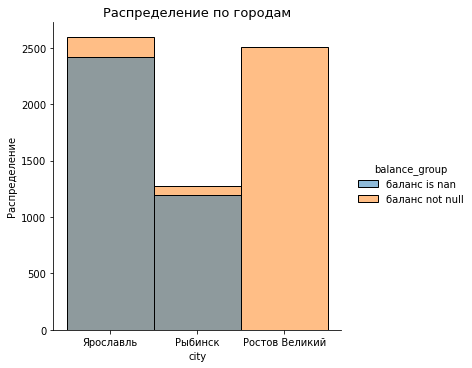

In [12]:
function_hist_nan(df, df['city'], 'по городам')

In [13]:
# # 
# print('количество клиентов с нулевым балансом',len(df[df['balance'] == 0]))
# print('количество клиентов положительным балансом',len(df[df['balance'] > 0]))

# df = df.fillna(0)
# print('количество пропусков после заполнения', df['balance'].isna().sum())
# print('процент пропусков после заполнения', ((df['balance'].isna().sum())/len(df)*100))

мы еще раз убедились, что в списке не было клиентов с нулевым балансом, а это не реально, с учетом того, что в списке есть ушедшие клиенты

значит, мы все сделали правильно

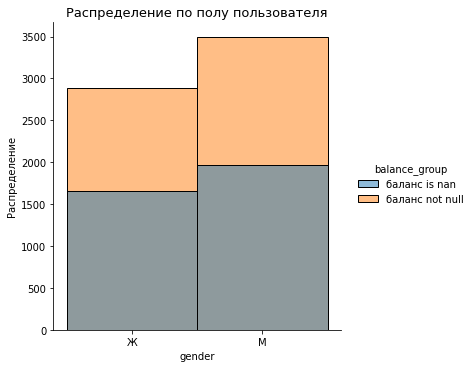

In [14]:
function_hist_nan(df, df['gender'], 'по полу пользователя')

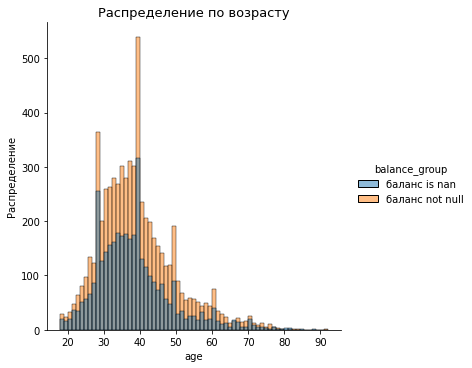

In [15]:
function_hist_nan(df, df['age'], 'по возрасту')

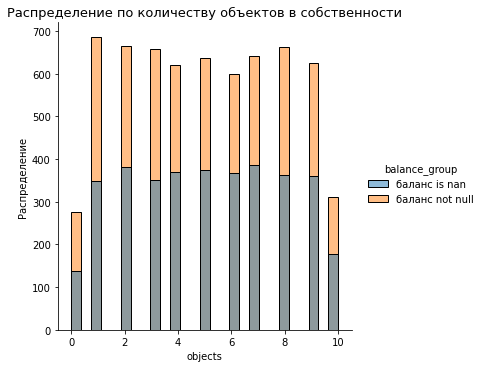

In [16]:
function_hist_nan(df, df['objects'], 'по количеству объектов в собственности')

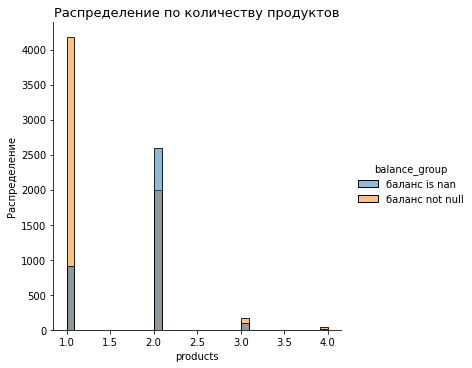

In [17]:
function_hist_nan(df, df['products'], 'по количеству продуктов')

- у клиентов с одним объектом - низкий процент пропусков
- у клиентов с двумя объектам - пропуски у большего числа людей

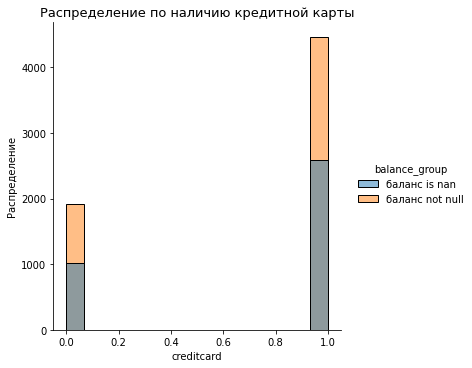

In [18]:
function_hist_nan(df, df['creditcard'], 'по наличию кредитной карты')

Пока картина не полная, посмотрим, сколько у нас клиентов с нулевым балансом

In [19]:
print('количество пропусков после заполнения', df[df['balance']==0]['balance'].count())
print('процент пропусков после заполнения', ((df[df['balance']==0]['balance'].count())/len(df)*100))

количество пропусков после заполнения 0
процент пропусков после заполнения 0.0


Сравним данные, посмотрим, может быть в Ростове нет пользователей с 2 продуктами, которые большое количество пропусков (в процентном соотношении)

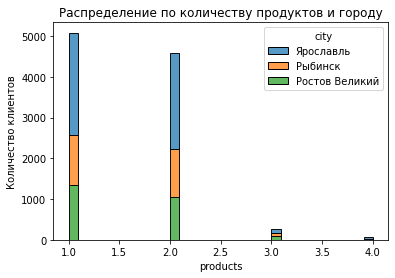

In [20]:
sns.histplot(data=df, x='products', hue='city', multiple="stack")
plt.title(f'Распределение по количеству продуктов и городу')
plt.ylabel('Количество клиентов')
plt.show();

In [21]:
print('количество клиентов из Ростова Великого с двумя продуктами', 
     len( df.query('city == "Ростов Великий" and products ==2')))

количество клиентов из Ростова Великого с двумя продуктами 1040


- не может быть такого, чтони у одного клиента нет нулевого баланса, даже у тех, кто ушел
- крайне подозрительно, что в Ростове нет клиентов с пропусками и нулевыми балансом, но спорить с данными мы не будем
- поскольку как минимум часть пропусков является нулевыми значениями, замена на другие значения приведет к перекосу данных
- принимаю решение не заменять пропуски

In [22]:
# df=df.dropna()
# print(df['balance'].isna().sum())
# print(len(df)) # количество строк оставшегося датасета

#### Анализ выбросов

In [23]:
def function(data,column):
    'Функция рассчета количества выбросов'
    q1=np.percentile(data[column], 25)
    q3=np.percentile(data[column], 75)
    diff=q3-q1
    min_out=q1-diff*1.5
    max_out=q3+diff*1.5

    print('Количество выбросов:',data[np.logical_or(data[column]<min_out,data[column]>max_out)][column].count(),
         '\nЗначения churn выбросов '+str(column)+':',data[np.logical_or(data[column]<min_out,data[column]>max_out)]['churn'].unique())
    
for name in df.describe().columns:
    print(name)
    function(df,name)

userid
Количество выбросов: 0 
Значения churn выбросов userid: []
score
Количество выбросов: 15 
Значения churn выбросов score: [1]
age
Количество выбросов: 359 
Значения churn выбросов age: [1 0]
objects
Количество выбросов: 0 
Значения churn выбросов objects: []
balance
Количество выбросов: 0 
Значения churn выбросов balance: []
products
Количество выбросов: 60 
Значения churn выбросов products: [1]
creditcard
Количество выбросов: 0 
Значения churn выбросов creditcard: []
loyalty
Количество выбросов: 0 
Значения churn выбросов loyalty: []
estimated_salary
Количество выбросов: 0 
Значения churn выбросов estimated_salary: []
churn
Количество выбросов: 2037 
Значения churn выбросов churn: [1]


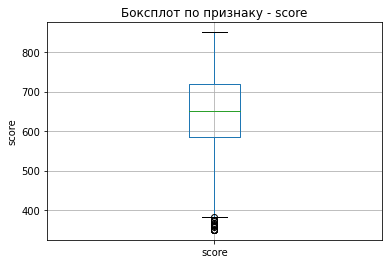

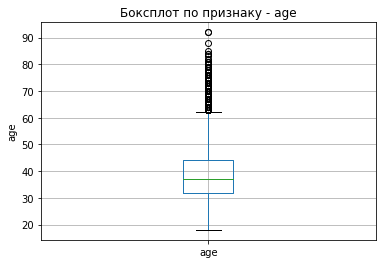

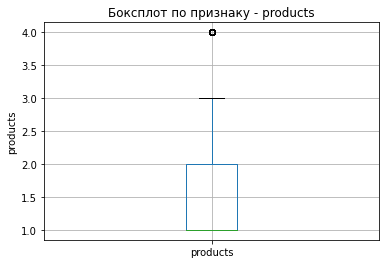

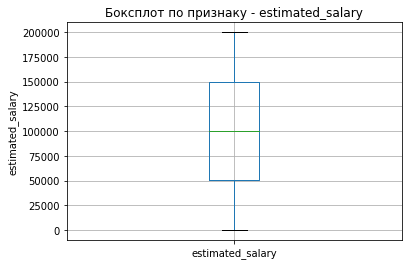

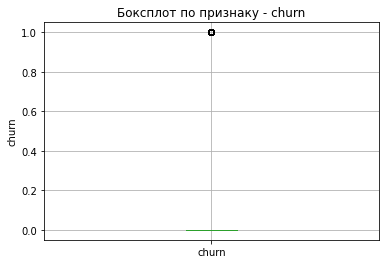

In [24]:
# создадим список с необходимыми названиями колонок-признаков
columns = ['score', 'age', 'products', 'estimated_salary', 'churn']

# построим боксплоты по признакам, "оберенем" их в цикл
for column in columns:
    df.boxplot(column)
    plt.title(f'Ящик по признаку - {column}')
    plt.ylabel(column)
    plt.show();

в данный есть выбросы:
- баллы кредитного скоринга меньше 385
- возраст больле 62
- количество объектов в собственности больше 3
- скорее всего, выбросы в churn появились из за кучности у медианы

прежде чем удалить выбросы, посмотрим, сколько их в процентах (кроме churn, его мы трогать не будем

In [25]:
len(df.query('age > 62 or score < 385 or products > 3')) /len(df)

0.0433

меньше 5%, можем избавиться от выбросов

In [26]:
df = df.query('age <= 62 and score >= 385 and products <= 3')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9567 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            9567 non-null   int64  
 1   score             9567 non-null   int64  
 2   city              9567 non-null   object 
 3   gender            9567 non-null   object 
 4   age               9567 non-null   int64  
 5   objects           9567 non-null   int64  
 6   balance           6102 non-null   float64
 7   products          9567 non-null   int64  
 8   creditcard        9567 non-null   int64  
 9   loyalty           9567 non-null   int64  
 10  estimated_salary  9567 non-null   float64
 11  churn             9567 non-null   int64  
 12  balance_group     9567 non-null   object 
dtypes: float64(2), int64(8), object(3)
memory usage: 1.0+ MB


данные готовы к дальнейшей работе

### Исследовательский анализ данных
#### Построим гистограммы

In [27]:
# df_churn = df.query('churn == 1')
# print(len(df_churn))

In [28]:
# напишем функцию 

def function_hist(data,column, name):
    sns.displot(data,x=column,hue='churn')
    plt.title('Распределение '+name, fontsize=13)
    plt.ylabel('Распределение')
    plt.show()

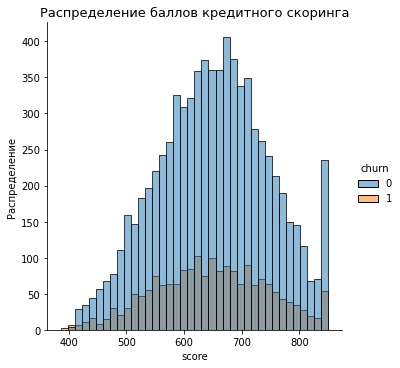

In [29]:
function_hist(df, df['score'],'баллов кредитного скоринга')

- распределение примерно одинаковое, ничего интересного

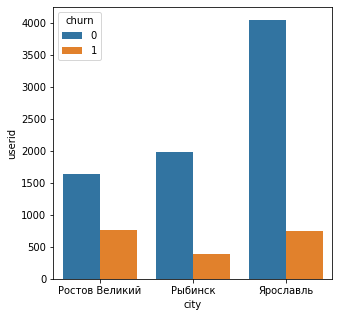

In [30]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df.groupby(['churn','city']).agg({'userid':'count'}).reset_index(),
            x='city',
            hue='churn',
            y='userid')
plt.show()

- в абсолютных величинах, отток из Ярославля и Ростова Великого примерно равный
- но вот если взглянуть на отношение ушедших и оставшихся, в Ростове отток составит примерно половину, тогда как в Ярославле - меньше четверти

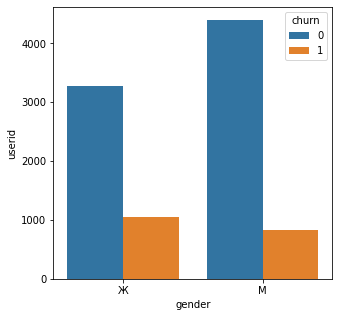

In [31]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df.groupby(['churn','gender']).agg({'userid':'count'}).reset_index(),
            x='gender',
            hue='churn',
            y='userid')
plt.show()

- Женщины чаще отказываются от услуг банка, даже с учетом того, что пользователей-мужчин больше примерно на 1000

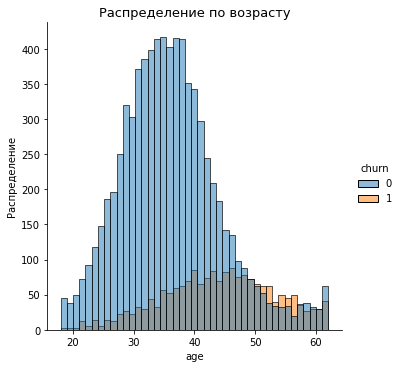

In [32]:
function_hist(df, df['age'], 'по возрасту')

- доля оттока приближается к оставшимся или даже превышает ее примерно в 50-60 лет

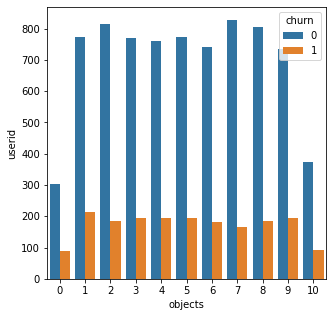

In [33]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df.groupby(['churn','objects']).agg({'userid':'count'}).reset_index(),
            x='objects',
            hue='churn',
            y='userid')
plt.show()

- не видим аномалий

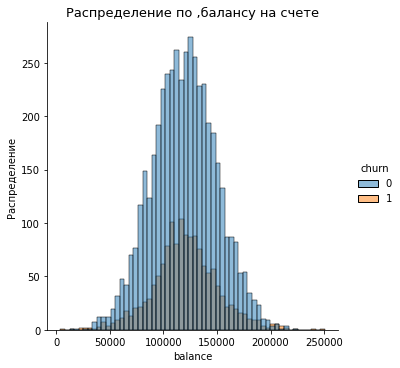

In [34]:
function_hist(df, df['balance'], 'по ,балансу на счете')

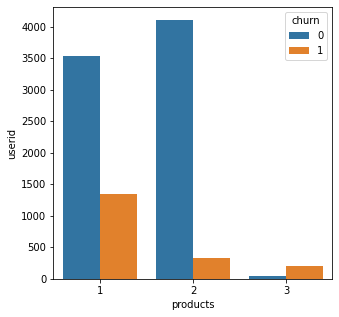

In [35]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df.groupby(['churn','products']).agg({'userid':'count'}).reset_index(),
            x='products',
            hue='churn',
            y='userid')
plt.show()

- пользователи с 3 и 4 продуктами уходят чаще (в процентном соотношении)
- пользователи с 2 продуктами практически не уходят

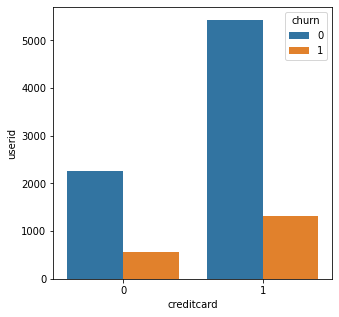

In [36]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df.groupby(['churn','creditcard']).agg({'userid':'count'}).reset_index(),
            x='creditcard',
            hue='churn',
            y='userid')
plt.show()

- не видим аномалий

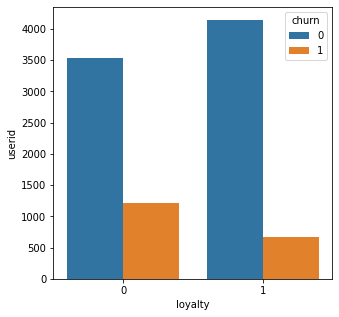

In [37]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df.groupby(['churn','loyalty']).agg({'userid':'count'}).reset_index(),
            x='loyalty',
            hue='churn',
            y='userid')
plt.show()

- активные клиенты уходят реже

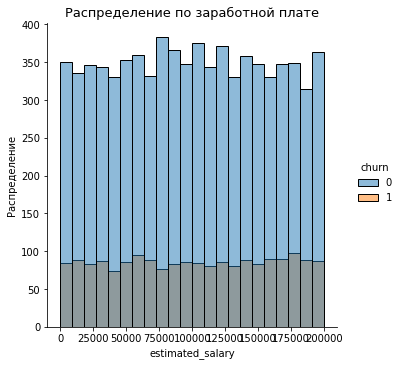

In [38]:
function_hist(df, df['estimated_salary'], 'по заработной плате')


- не видим аномалий

#### оценим данные методом describe()

In [39]:
df.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,9.567000e+03,9567.000000,9567.000000,9567.000000,6102.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000
mean,1.573368e+07,650.718721,37.734713,5.015052,119833.699579,1.516045,0.705237,0.503711,100090.253758,0.197554
std,7.186030e+04,96.059543,8.782816,2.887859,30117.958823,0.549769,0.455960,0.500012,57524.690666,0.398175
min,1.560844e+07,386.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.567121e+07,584.000000,32.000000,3.000000,100116.707500,1.000000,0.000000,0.000000,51013.655000,0.000000
50%,1.573406e+07,652.000000,37.000000,5.000000,119791.215000,1.000000,1.000000,1.000000,100127.710000,0.000000
75%,1.579575e+07,717.000000,43.000000,7.000000,139542.510000,2.000000,1.000000,1.000000,149464.930000,0.000000
max,1.585843e+07,850.000000,62.000000,10.000000,250898.090000,3.000000,1.000000,1.000000,199992.480000,1.000000


#### оценим выбросы

In [40]:
# def function(data,column):
#     'Функция рассчета количества выбросов'
#     q1=np.percentile(data[column], 25)
#     q3=np.percentile(data[column], 75)
#     diff=q3-q1
#     min_out=q1-diff*1.5
#     max_out=q3+diff*1.5

#     print('Количество выбросов:',data[np.logical_or(data[column]<min_out,data[column]>max_out)][column].count(),
#          '\nЗначения churn выбросов '+str(column)+':',data[np.logical_or(data[column]<min_out,data[column]>max_out)]['churn'].unique())
    
# for name in df.describe().columns:
#     print(name)
#     function(df,name)

In [41]:
# средние величины показателей для оттока и оставшихся

df_grouped=df.groupby('churn',as_index=False).mean()
df_grouped

,churn,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
0,0,1.573387e+07,651.532500,36.193826,5.035561,119560.716016,1.545786,0.706917,0.539664,99848.972807
1,1,1.573293e+07,647.413228,43.993651,4.931746,120731.303296,1.395238,0.698413,0.357672,101070.314000


- как мы замечали ранее, отток распространен среди более старшего населения, но на гистограмме
границы были другими
- активность клиента влияет на его возмоный уход
- остальные показатели в пределах статистической погрешности

#### зависимость данных, построим матрицу корреляций

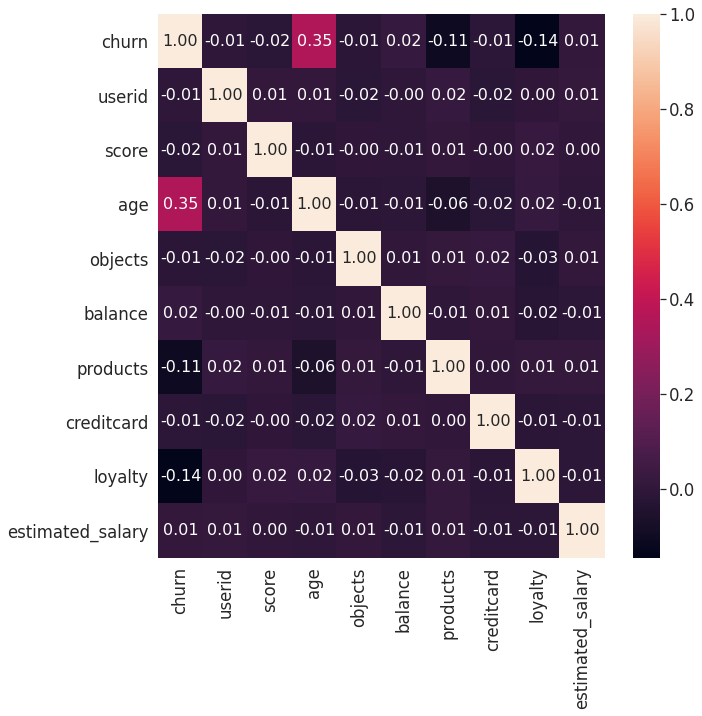

In [42]:
cm=df[df_grouped.columns].corr()
sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='.2f',annot_kws={"size": 16});

мы видим, что по шкале Чеддока:
- возраст связан с оттоком - Умеренно: 0,35
- активность и количество продуктов - Слабая: -0,14 и -0,11 соответственно 
- остальное - стат. погрешность

### Сформулируем и проверим статистические гипотезы
#### Гипотеза 1
- Н0 - средняя заработная плата между теми клиентами, которые ушли и теми, которые остались равна
- Н1 - средняя заработная плата между теми клиентами, которые ушли и теми, которые остались не равна

t-критерий Стьюдента — общее название для класса методов статистической проверки гипотез (статистических критериев), основанных на распределении Стьюдента. Наиболее частые случаи применения t-критерия связаны с проверкой равенства средних значений в двух выборках.

необходима проверка данных на нормальность

<div class="alert alert-success"> 
    
Для выборок больше 30 наблюдений нормальность не нужна, тест Стьюдента корректно использовать, если выборки не содержат выбросы
    
</div>

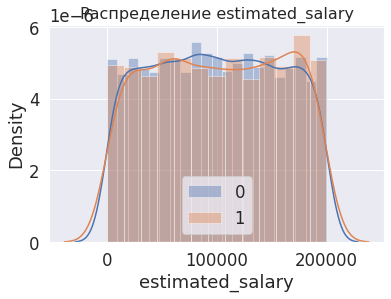

In [43]:
sns.distplot(df.query("churn==0")['estimated_salary'],label='0')
sns.distplot(df.query("churn==1")['estimated_salary'],label='1')
plt.title('Распределение estimated_salary',fontsize=16)
plt.legend()
plt.show()

- все нормально

In [44]:
alpha=0.05

print('Дисперсия ушедних:',df.query("churn==1")['estimated_salary'].var())
print('Дисперсия оставшихся:',df.query("churn==0")['estimated_salary'].var())

Дисперсия ушедних: 3370731040.746117
Дисперсия оставшихся: 3294057066.6482553


- можно сказать, что дисперсии равны

In [45]:
results = st.ttest_ind(
    df.query("churn==0")['estimated_salary'], 
    df.query("churn==1")['estimated_salary'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4083561087686324
Не получилось отвергнуть нулевую гипотезу


выводы очевидны, мы не можем отрицать то, что средняя заработная плата между теми клиентами, которые ушли и теми, которые остались равна

#### Гипотеза 2
- Н0 - средний баланс на счёте между теми клиентами, которые ушли и теми, которые остались равна
- Н1 - средний баланс на счёте между теми клиентами, которые ушли и теми, которые остались не равна

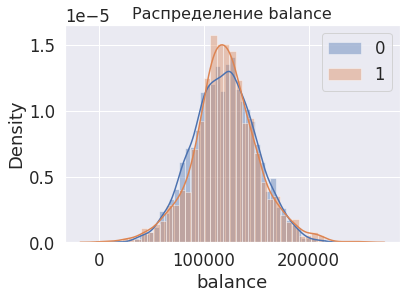

In [46]:
sns.distplot(df.query("churn==0")['balance'],label='0')
sns.distplot(df.query("churn==1")['balance'],label='1')
plt.title('Распределение balance',fontsize=16)
plt.legend()
plt.show()

- все нормально

In [47]:
alpha=0.05

print('Дисперсия ушедних:',df.query("churn==1")['balance'].var())
print('Дисперсия оставшихся:',df.query("churn==0")['balance'].var())

Дисперсия ушедних: 943902752.0943907
Дисперсия оставшихся: 895775973.6771116


- дисперсия отличается, так что equal_var=False

In [48]:
results = st.ttest_ind(
    df.query("churn==0")['balance'], 
    df.query("churn==1")['balance'], equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: nan
Не получилось отвергнуть нулевую гипотезу


мы не можем отрицать то, что средний баланс на счёте между теми клиентами, которые ушли и теми, которые остались равна

### Выводы
#### Перед нами стояла задача:
- Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.
#### В исследовании мы выполнили следующие пункты:
1. Провели предобработку данных и исследовательский анализ данных
- побороли проблему пропусков
- в абсолютных величинах, оток из Ярославля и Ростова Великого примерно равный
- но вот если взглянуть на на отношение ушедших и оставшихся, в Ростове оттко составит приверно половину, тогда как в Ярославле - меньше четверти
- Женщины чаще отвказываются от услуг банка, даже с учетом того, что пользователей-мужчин больше примерно на 1000
- доля оттока приближается к оставшимся или даже превышает ее приверно в 50-60 лет
- пользователи с 3 и 4 продуктами уходят чаще (в процентном соотношении)
- пользователи с 2 продуктами практически не уходят
- выбросы на превышают 5%, мы их безболезненно удалили
2. выводы по гипотезам
- мы не можем отрицать то, что средняя заработная плата между теми клиентами, которые ушли и теми, которые остались равна
- мы не можем отрицать то, что средний баланс на счёте между теми клиентами, которые ушли и теми, которые остались равна
#### На основании исследования, мы делаем вывод, что портрет клиента, склонного к оттоку:
- пользователь с 0 лояльностью
- скорее всего, женского пола 
- город - Ростов Великий
- возраст 40-50 лет и старше
- пользуется 3 продуктами

### Рекомендации
- явные проблемы с удержанием клиентов в городе Ростов Великий, возможны технические проблемы или неосведомленность об специальных условиях и акциях, которыми есть возможность воспользоваться
- есть проблемы с удержанием клиентов старшего возраста, стоит уделить внимание этой группе
- по непонятной причине, женщины чаще отказываются от услуг, требуется дополнительная аналитика и соц.опрос
- большой отток клиентов с 3 и более продуктами. в данном случае стоит разобраться, если большинство этих продуктов связанны с кредитованием, то, возможно, клиенты пользуются услугами рефинансирования в другом банке и перестают быть нашими клиентами